# Install TVM

[installation link](https://tvm.apache.org/docs/install/from_source.html)

1. launch c5 with deep learning AMI
1. cat "termcapinfo xterm* ti@:te@" > ~/.screenrc
1. screen

1. source activate tensorflow_p36
1. sudo apt-get update -y
1. sudo apt-get install -y llvm
1. sudo find / -name "llvm-config*"

## Follow the TVM installation from source

In [ ]:
git clone --recursive https://github.com/apache/incubator-tvm tvm
cd tvm
mkdir build
cp cmake/config.cmake build

vim build/config.cmake
  set(USE_CUDA ON)
  set(USE_LLVM ON)
  set(USE_LLVM /usr/lib/llvm-6.0/bin/llvm-config)

cd build
cmake ..
make -j4
sudo make install
cd ..
cd python; python setup.py install --user; cd ..
cd topi/python; python setup.py install --user; cd ../..

## Download the source code of Yolo v3

In [ ]:
mkdir darknet-tvm
cd darknet-tvm
wget https://docs.tvm.ai/_downloads/835a4def1e256b7a1f711621fc031418/from_darknet.ipynb

In [1]:
%matplotlib inline

Matplotlib is building the font cache using fc-list. This may take a moment.


Compile YOLO-V2 and YOLO-V3 in DarkNet Models
=============================================
**Author**: `Siju Samuel <https://siju-samuel.github.io/>`_

This article is an introductory tutorial to deploy darknet models with TVM.
All the required models and libraries will be downloaded from the internet by the script.
This script runs the YOLO-V2 and YOLO-V3 Model with the bounding boxes
Darknet parsing have dependancy with CFFI and CV2 library
Please install CFFI and CV2 before executing this script

.. code-block:: bash

In [2]:
!pip install cffi
!pip install opencv-python

In [3]:
# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys

# tvm, relay
import tvm
from tvm import te
from tvm import relay
from ctypes import *
from tvm.contrib.download import download_testdata
from tvm.relay.testing.darknet import __darknetffi__
import tvm.relay.testing.yolo_detection
import tvm.relay.testing.darknet

Choose the model
-----------------------
Models are: 'yolov2', 'yolov3' or 'yolov3-tiny'



In [4]:
# Model name
MODEL_NAME = 'yolov3'

Download required files
-----------------------
Download cfg and weights file if first time.



In [5]:
CFG_NAME = MODEL_NAME + '.cfg'
WEIGHTS_NAME = MODEL_NAME + '.weights'
REPO_URL = 'https://github.com/dmlc/web-data/blob/master/darknet/'
CFG_URL = REPO_URL + 'cfg/' + CFG_NAME + '?raw=true'
WEIGHTS_URL = 'https://pjreddie.com/media/files/' + WEIGHTS_NAME

cfg_path = download_testdata(CFG_URL, CFG_NAME, module="darknet")
weights_path = download_testdata(WEIGHTS_URL, WEIGHTS_NAME, module="darknet")

# Download and Load darknet library
if sys.platform in ['linux', 'linux2']:
    DARKNET_LIB = 'libdarknet2.0.so'
    DARKNET_URL = REPO_URL + 'lib/' + DARKNET_LIB + '?raw=true'
elif sys.platform == 'darwin':
    DARKNET_LIB = 'libdarknet_mac2.0.so'
    DARKNET_URL = REPO_URL + 'lib_osx/' + DARKNET_LIB + '?raw=true'
else:
    err = "Darknet lib is not supported on {} platform".format(sys.platform)
    raise NotImplementedError(err)

lib_path = download_testdata(DARKNET_URL, DARKNET_LIB, module="darknet")

...100%, 0.02 MB, 20 KB/s, 0 seconds passed
...100%, 236.52 MB, 169 KB/s, 1427 seconds passed
...100%, 0.58 MB, 98 KB/s, 5 seconds passed


In [6]:
DARKNET_LIB = __darknetffi__.dlopen(lib_path)
net = DARKNET_LIB.load_network(cfg_path.encode('utf-8'), weights_path.encode('utf-8'), 0)
dtype = 'float32'
batch_size = 1

data = np.empty([batch_size, net.c, net.h, net.w], dtype)
shape_dict = {'data': data.shape}
print("Converting darknet to relay functions...")
mod, params = relay.frontend.from_darknet(net, dtype=dtype, shape=data.shape)

Converting darknet to relay functions...


Import the graph to Relay
-------------------------
compile the model



In [7]:
target = 'llvm'
target_host = 'llvm'
ctx = tvm.cpu(0)
data = np.empty([batch_size, net.c, net.h, net.w], dtype)
shape = {'data': data.shape}
print("Compiling the model...")
with relay.build_config(opt_level=3):
    graph, lib, params = relay.build(mod,
                                     target=target,
                                     target_host=target_host,
                                     params=params)

[neth, netw] = shape['data'][2:] # Current image shape is 608x608

Compiling the model...
...100%, 0.02 MB, 104 KB/s, 0 seconds passed


Cannot find config for target=llvm, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 3, 416, 416), 'float32'), ('TENSOR', (32, 3, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 416, 416), 'float32'), ('TENSOR', (64, 32, 3, 3), 'float32'), (2, 2), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 64, 208, 208), 'float32'), ('TENSOR', (32, 64, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 208, 208), 'float32'), ('TENSOR', (64, 32, 3, 3), 'float32'), 

Load a test image
-----------------



In [8]:
test_image = 'dog.jpg'
print("Loading the test image...")
img_url = REPO_URL + 'data/' + test_image + '?raw=true'
img_path = download_testdata(img_url, test_image, "data")

data = tvm.relay.testing.darknet.load_image(img_path, netw, neth)

Loading the test image...
...100%, 0.16 MB, 193 KB/s, 0 seconds passed


Execute on TVM Runtime
----------------------
The process is no different from other examples.



Running the test image...
...100%, 0.01 MB, 13 KB/s, 0 seconds passed
...100%, 0.35 MB, 475 KB/s, 0 seconds passed


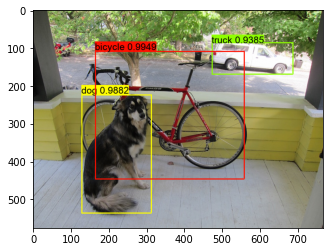

In [9]:
from tvm.contrib import graph_runtime

m = graph_runtime.create(graph, lib, ctx)

# set inputs
m.set_input('data', tvm.nd.array(data.astype(dtype)))
m.set_input(**params)
# execute
print("Running the test image...")

# detection
# thresholds
thresh = 0.5
nms_thresh = 0.45

m.run()
# get outputs
tvm_out = []
if MODEL_NAME == 'yolov2':
    layer_out = {}
    layer_out['type'] = 'Region'
    # Get the region layer attributes (n, out_c, out_h, out_w, classes, coords, background)
    layer_attr = m.get_output(2).asnumpy()
    layer_out['biases'] = m.get_output(1).asnumpy()
    out_shape = (layer_attr[0], layer_attr[1]//layer_attr[0],
                 layer_attr[2], layer_attr[3])
    layer_out['output'] = m.get_output(0).asnumpy().reshape(out_shape)
    layer_out['classes'] = layer_attr[4]
    layer_out['coords'] = layer_attr[5]
    layer_out['background'] = layer_attr[6]
    tvm_out.append(layer_out)

elif MODEL_NAME == 'yolov3':
    for i in range(3):
        layer_out = {}
        layer_out['type'] = 'Yolo'
        # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
        layer_attr = m.get_output(i*4+3).asnumpy()
        layer_out['biases'] = m.get_output(i*4+2).asnumpy()
        layer_out['mask'] = m.get_output(i*4+1).asnumpy()
        out_shape = (layer_attr[0], layer_attr[1]//layer_attr[0],
                     layer_attr[2], layer_attr[3])
        layer_out['output'] = m.get_output(i*4).asnumpy().reshape(out_shape)
        layer_out['classes'] = layer_attr[4]
        tvm_out.append(layer_out)

elif MODEL_NAME == 'yolov3-tiny':
    for i in range(2):
        layer_out = {}
        layer_out['type'] = 'Yolo'
        # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
        layer_attr = m.get_output(i*4+3).asnumpy()
        layer_out['biases'] = m.get_output(i*4+2).asnumpy()
        layer_out['mask'] = m.get_output(i*4+1).asnumpy()
        out_shape = (layer_attr[0], layer_attr[1]//layer_attr[0],
                     layer_attr[2], layer_attr[3])
        layer_out['output'] = m.get_output(i*4).asnumpy().reshape(out_shape)
        layer_out['classes'] = layer_attr[4]
        tvm_out.append(layer_out)
        thresh = 0.560

# do the detection and bring up the bounding boxes
img = tvm.relay.testing.darknet.load_image_color(img_path)
_, im_h, im_w = img.shape
dets = tvm.relay.testing.yolo_detection.fill_network_boxes((netw, neth), (im_w, im_h), thresh,
                                                      1, tvm_out)
last_layer = net.layers[net.n - 1]
tvm.relay.testing.yolo_detection.do_nms_sort(dets, last_layer.classes, nms_thresh)

coco_name = 'coco.names'
coco_url = REPO_URL + 'data/' + coco_name + '?raw=true'
font_name = 'arial.ttf'
font_url = REPO_URL + 'data/' + font_name + '?raw=true'
coco_path = download_testdata(coco_url, coco_name, module='data')
font_path = download_testdata(font_url, font_name, module='data')

with open(coco_path) as f:
    content = f.readlines()

names = [x.strip() for x in content]

tvm.relay.testing.yolo_detection.draw_detections(font_path, img, dets, thresh, names, last_layer.classes)
plt.imshow(img.transpose(1, 2, 0))
plt.show()